<a href="https://colab.research.google.com/github/walkidni/grayscale-image-colorization/blob/main/Small_Imagenet_RESNET_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
colorization_path = '/content/drive/MyDrive/colorization'
!tar -zxf /content/drive/MyDrive/colorization/smallval.tar.gz

Mounted at /content/drive


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm
from PIL import Image
from skimage import color
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# I. Data preparation

## 0. utils

In [3]:

def stack_lab(l, ab):
  return torch.cat((l, ab), dim=-3)

def lab2rgb(lab, to_numpy):
  dims = len(lab.shape)
  if lab.requires_grad :
    lab = lab.detach()
  lab = lab.permute((1,2,0)) if dims==3 else lab.permute((0,2,3,1))
  rgb = color.lab2rgb(lab)
  if to_numpy:
    return rgb
  else:
    return torch.from_numpy(rgb).permute(2,0,1) if dims==3 else torch.from_numpy(rgb).permute((0,3,1,2))

def to_rgb(l, ab, to_numpy=True):
  lab = stack_lab(l,ab)
  rgb = lab2rgb(lab, to_numpy = to_numpy)
  return rgb

## 1. using Imagenet validation set

In [4]:
# image processing rgb to lab
class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, transform=None):
        self.transform = transform
        self.data = datasets.ImageFolder(folder_path)



    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, _ = self.data[index]

        if self.transform:
            image = self.transform(image)

        lab_image = color.rgb2lab(image)
        lab_image = lab_image.astype(np.float32)
        L, ab = lab_image[:,:,0], lab_image[:,:,1:]
        L = torch.from_numpy(L).unsqueeze(dim=0)
        ab = torch.from_numpy(ab).permute((2,0,1))


        return L, ab

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop((256,256))
])

# data_dir = '/content/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/'
data_dir = '/content/ILSVRC2012_img_val_subset'
dataset = ColorizationDataset(data_dir, transform)


In [5]:
train_size = int(.8* len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator()
generator.manual_seed(0)
train_data, val_data = random_split(dataset, [train_size, val_size], generator=generator)


In [6]:
gray, chrome = train_data[0]
gray.shape, chrome.shape

(torch.Size([1, 256, 256]), torch.Size([2, 256, 256]))

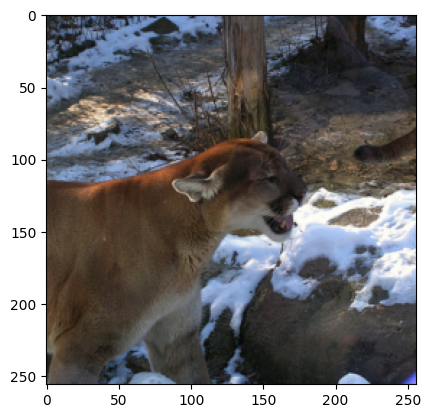

In [7]:
rgb = to_rgb(gray, chrome)
plt.imshow(rgb)

# III. Training Experimentation

## 0. utils

In [8]:
from tqdm import tqdm

def train_loop(model, loader, optimizer, backprop_loss=1):
    model.train()
    running_loss1 = 0.0
    running_loss2 = 0.0

    for grayscale_images, colored_images in tqdm(loader, leave=False):
        grayscale_images = grayscale_images.to(device)
        colored_images = colored_images.to(device)
        optimizer.zero_grad()

        # Forward pass
        predicted_images = model(grayscale_images)

        # Compute the loss
        loss1 = nn.L1Loss()(predicted_images, colored_images)
        loss2 = nn.MSELoss()(predicted_images, colored_images)

        # Backpropagation and weight updates
        loss = loss1 + loss2 if backprop_loss==0 else loss1 if backprop_loss==1 else loss2
        loss.backward()
        optimizer.step()

        running_loss1 += loss1.item()
        running_loss2 += loss2.item()

    # Calculate average loss
    average_loss1 = running_loss1 / len(loader)
    average_loss2 = running_loss2 / len(loader)

    return average_loss1, average_loss2

def plot_loss(loss, title, save_path):
    epochs = range(len(loss))

    # Plotting the losses
    plt.plot(epochs, loss)
    # Customize the plot
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)

    # Save the plot
    plt.savefig(save_path)
    plt.show()

    # Close the plot to free up resources
    plt.close()


# Train RESNET UNet on imagenet validation set

In [9]:
! pip install -qU segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.8 MB/s eta 0:00:00


In [13]:
from torchvision.models.resnet import resnet101
import segmentation_models_pytorch as smp

class UNet(nn.Module):
  def __init__(self, encoder_name, encoder_weights = 'imagenet', freeze_encoder = True):
    super().__init__()

    self.model = smp.Unet(encoder_name, encoder_weights=encoder_weights, decoder_use_batchnorm=True, in_channels=1)
    self.model.segmentation_head[0] = nn.Conv2d(16, 2, kernel_size=3, padding=1)

    if freeze_encoder:
      for param in self.model.encoder.parameters():
        param.requires_grad = False

  def forward(self, x):
    return self.model(x)

res_unet= UNet(encoder_name='resnet152',encoder_weights='imagenet',freeze_encoder=True)
# vgg_unet= UNet(encoder_name='vgg19_bn',encoder_weights='imagenet',freeze_encoder=True)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:05<00:00, 47.1MB/s]


In [14]:
# config
model_name = 'smallimagenet-resunet152'
model = res_unet
backprop_loss = 2
batch_size = 32
model.to(device)

# Initialize U-Net model and loader and optimizer
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


optimizer = optim.Adam(model.parameters())

# training loop
l1_hist = []
l2_hist = []

Epoch 1/50:  MAE Loss: 9.764598888397217, MSE Loss: 232.3209898071289


Epoch 2/50:  MAE Loss: 9.499586078643798, MSE Loss: 207.68618505859374


Epoch 3/50:  MAE Loss: 9.357215118408202, MSE Loss: 200.52463122558595


Epoch 4/50:  MAE Loss: 9.32648652267456, MSE Loss: 197.48107049560548


Epoch 5/50:  MAE Loss: 9.215325351715087, MSE Loss: 193.03083404541016


Epoch 6/50:  MAE Loss: 9.148415069580079, MSE Loss: 190.26903057861327


Epoch 7/50:  MAE Loss: 9.012570255279542, MSE Loss: 185.71513372802735


Epoch 8/50:  MAE Loss: 8.93526826095581, MSE Loss: 181.24051318359375


Epoch 9/50:  MAE Loss: 8.814897953033448, MSE Loss: 177.0365870361328


Epoch 10/50:  MAE Loss: 8.694484016418457, MSE Loss: 172.09990246582032


Epoch 11/50:  MAE Loss: 8.60698162841797, MSE Loss: 168.57486950683594


Epoch 12/50:  MAE Loss: 8.525921161651612, MSE Loss: 164.23598065185547


Epoch 13/50:  MAE Loss: 8.390199039459228, MSE Loss: 158.48235668945313


Epoch 14/50:  MAE Loss: 8.332592464447021, MSE Loss: 155.2761478881836


Epoch 15/50:  MAE Loss: 8.153185600280763, MSE Loss: 148.50845336914062


Epoch 16/50:  MAE Loss: 8.070493995666505, MSE Loss: 144.72229614257813


Epoch 17/50:  MAE Loss: 7.966270561218262, MSE Loss: 141.0968158569336


Epoch 18/50:  MAE Loss: 7.849406547546387, MSE Loss: 136.94645166015624


Epoch 19/50:  MAE Loss: 7.774039867401123, MSE Loss: 133.56959759521484


Epoch 20/50:  MAE Loss: 7.637898662567139, MSE Loss: 129.1885473022461


Epoch 21/50:  MAE Loss: 7.5908232612609865, MSE Loss: 126.56604162597657


Epoch 22/50:  MAE Loss: 7.515286869049072, MSE Loss: 124.22610064697265


Epoch 23/50:  MAE Loss: 7.398144123077393, MSE Loss: 120.71095129394531


Epoch 24/50:  MAE Loss: 7.315009483337402, MSE Loss: 118.02127185058593


Epoch 25/50:  MAE Loss: 7.2190939102172855, MSE Loss: 114.97934051513671


Epoch 26/50:  MAE Loss: 7.174670097351075, MSE Loss: 113.61414227294922


Epoch 27/50:  MAE Loss: 7.103842540740967, MSE Loss: 111.03805334472656


Epoch 28/50:  MAE Loss: 7.016271430969239, MSE Loss: 108.38961639404297


Epoch 29/50:  MAE Loss: 6.969961826324463, MSE Loss: 106.89759680175781


Epoch 30/50:  MAE Loss: 6.905893047332763, MSE Loss: 104.93678784179687


Epoch 31/50:  MAE Loss: 6.883619125366211, MSE Loss: 104.4235512084961


Epoch 32/50:  MAE Loss: 6.835621997833252, MSE Loss: 102.2835523071289


Epoch 33/50:  MAE Loss: 6.762944198608398, MSE Loss: 100.38576513671875


Epoch 34/50:  MAE Loss: 6.740696365356445, MSE Loss: 99.33438165283204


Epoch 35/50:  MAE Loss: 6.698207347869873, MSE Loss: 98.40847546386719


Epoch 36/50:  MAE Loss: 6.59347087097168, MSE Loss: 94.85749444580078


Epoch 37/50:  MAE Loss: 6.596564632415771, MSE Loss: 95.1750542602539


Epoch 38/50:  MAE Loss: 6.5096213836669925, MSE Loss: 92.92422442626953


Epoch 39/50:  MAE Loss: 6.461411876678467, MSE Loss: 91.94351049804688


Epoch 40/50:  MAE Loss: 6.48959334564209, MSE Loss: 92.05553601074219


Epoch 41/50:  MAE Loss: 6.40812565612793, MSE Loss: 90.02049908447266


Epoch 42/50:  MAE Loss: 6.378060222625733, MSE Loss: 89.03720510864258


Epoch 43/50:  MAE Loss: 6.283204402923584, MSE Loss: 86.40202651977539


Epoch 44/50:  MAE Loss: 6.311515758514404, MSE Loss: 87.08672076416016


Epoch 45/50:  MAE Loss: 6.305150833129883, MSE Loss: 86.67103332519531


Epoch 46/50:  MAE Loss: 6.192772605895996, MSE Loss: 83.81432891845704


Epoch 47/50:  MAE Loss: 6.18799923324585, MSE Loss: 83.79788543701171


Epoch 48/50:  MAE Loss: 6.17455736541748, MSE Loss: 83.36666943359376


Epoch 49/50:  MAE Loss: 6.170680271148681, MSE Loss: 82.8860428161621


Epoch 50/50:  MAE Loss: 6.249180053710938, MSE Loss: 85.2173641052246


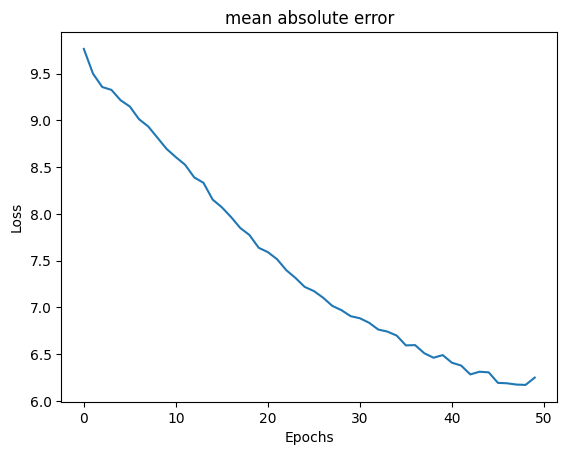

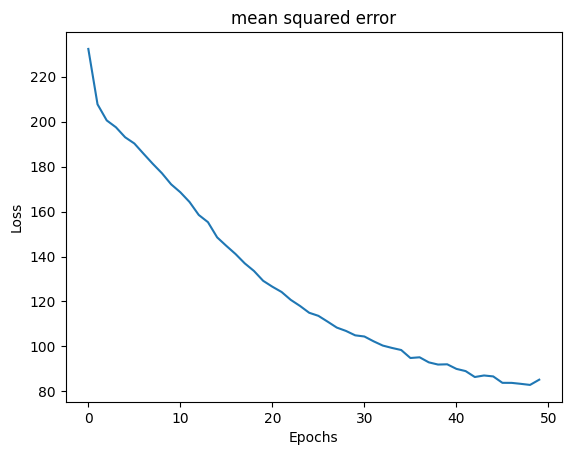

In [15]:
epochs = 50
for epoch in range(epochs):
    l1, l2 = train_loop(model, trainloader, optimizer, backprop_loss)
    print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
    l1_hist.append(l1)
    l2_hist.append(l2)
torch.save(model.state_dict(), f'/content/drive/MyDrive/colorization/models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'/content/drive/MyDrive/colorization/plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'/content/drive/MyDrive/colorization/plots/L2-{model_name}.png')

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/colorization/models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'/content/drive/MyDrive/colorization/plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'/content/drive/MyDrive/colorization/plots/L2-{model_name}.png')

training_dict = {}
training_dict[model_name] = l1_hist, l2_hist

In [16]:
epochs = 20
for epoch in range(epochs):
    l1, l2 = train_loop(model, trainloader, optimizer, backprop_loss)
    print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
    l1_hist.append(l1)
    l2_hist.append(l2)

Epoch 1/20:  MAE Loss: 6.099142295837402, MSE Loss: 81.13894421386719


Epoch 2/20:  MAE Loss: 6.041535762786865, MSE Loss: 79.61746411132812


Epoch 3/20:  MAE Loss: 6.060242500305176, MSE Loss: 80.08733743286133


Epoch 4/20:  MAE Loss: 6.035036148071289, MSE Loss: 79.18571374511718


Epoch 5/20:  MAE Loss: 5.942035438537598, MSE Loss: 77.05102752685546


Epoch 6/20:  MAE Loss: 5.931401737213135, MSE Loss: 77.09507949829101


Epoch 7/20:  MAE Loss: 5.910144973754883, MSE Loss: 76.30788748168945


Epoch 8/20:  MAE Loss: 5.9114845237731934, MSE Loss: 75.94952056884766


Epoch 9/20:  MAE Loss: 5.8492708625793455, MSE Loss: 74.63635705566406


Epoch 10/20:  MAE Loss: 5.827656929016113, MSE Loss: 74.38275451660157


Epoch 11/20:  MAE Loss: 5.8425494499206545, MSE Loss: 74.40592614746093


Epoch 12/20:  MAE Loss: 5.783576889038086, MSE Loss: 73.09863482666016


Epoch 13/20:  MAE Loss: 5.823589424133301, MSE Loss: 73.84378631591797


Epoch 14/20:  MAE Loss: 5.779888603210449, MSE Loss: 72.74639309692382


Epoch 15/20:  MAE Loss: 5.753601409912109, MSE Loss: 72.1790007019043


Epoch 16/20:  MAE Loss: 5.759501003265381, MSE Loss: 72.1468624267578


Epoch 17/20:  MAE Loss: 5.65693790435791, MSE Loss: 69.9497658996582


Epoch 18/20:  MAE Loss: 5.6976209754943845, MSE Loss: 70.63502502441406


Epoch 19/20:  MAE Loss: 5.67171862411499, MSE Loss: 70.16777865600586


Epoch 20/20:  MAE Loss: 5.708412990570069, MSE Loss: 70.85763668823242


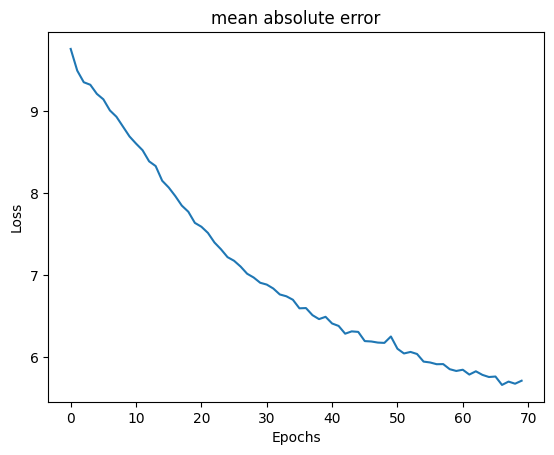

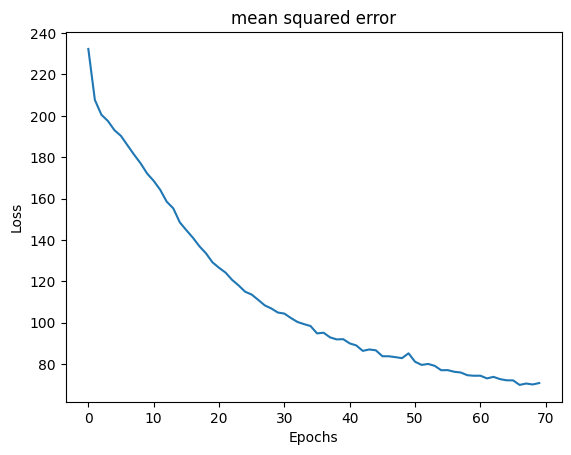

In [17]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/colorization/models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'/content/drive/MyDrive/colorization/plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'/content/drive/MyDrive/colorization/plots/L2-{model_name}.png')

In [18]:
epochs = 20
for epoch in range(epochs):
    l1, l2 = train_loop(model, trainloader, optimizer, backprop_loss)
    print(f"Epoch {epoch+1}/{epochs}:  MAE Loss: {l1}, MSE Loss: {l2}")
    l1_hist.append(l1)
    l2_hist.append(l2)

Epoch 1/20:  MAE Loss: 5.633202964782715, MSE Loss: 69.28737002563477


Epoch 2/20:  MAE Loss: 5.602554855346679, MSE Loss: 68.71408517456055


Epoch 3/20:  MAE Loss: 5.5763054428100585, MSE Loss: 67.8564725036621


Epoch 4/20:  MAE Loss: 5.5485644607543945, MSE Loss: 67.23332614135742


Epoch 5/20:  MAE Loss: 5.576536960601807, MSE Loss: 67.85575588989258


Epoch 6/20:  MAE Loss: 5.501097972869873, MSE Loss: 66.26498211669922


Epoch 7/20:  MAE Loss: 5.568780029296875, MSE Loss: 67.28907968139649


Epoch 8/20:  MAE Loss: 5.457563186645507, MSE Loss: 65.01186450195313


Epoch 9/20:  MAE Loss: 5.552225234985351, MSE Loss: 67.05768682861329


Epoch 10/20:  MAE Loss: 5.5133117599487305, MSE Loss: 66.37380325317383


Epoch 11/20:  MAE Loss: 5.442086151123047, MSE Loss: 64.74977584838867


Epoch 12/20:  MAE Loss: 5.434490669250488, MSE Loss: 64.54269921875


Epoch 13/20:  MAE Loss: 5.412955410003662, MSE Loss: 64.05635232543945


Epoch 14/20:  MAE Loss: 5.40149877166748, MSE Loss: 63.805808380126955


Epoch 15/20:  MAE Loss: 5.343633598327637, MSE Loss: 62.53606283569336


Epoch 16/20:  MAE Loss: 5.379075748443603, MSE Loss: 63.10252926635742


Epoch 17/20:  MAE Loss: 5.384185279846191, MSE Loss: 63.49004702758789


Epoch 18/20:  MAE Loss: 5.362600994110108, MSE Loss: 62.70772271728516


Epoch 19/20:  MAE Loss: 5.332620704650879, MSE Loss: 62.273515686035154


Epoch 20/20:  MAE Loss: 5.34762899017334, MSE Loss: 62.39555200195313


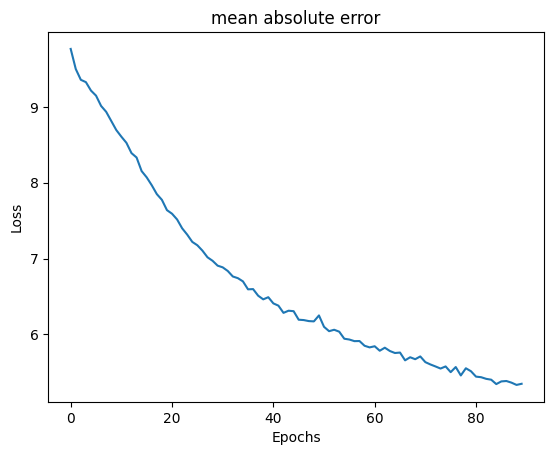

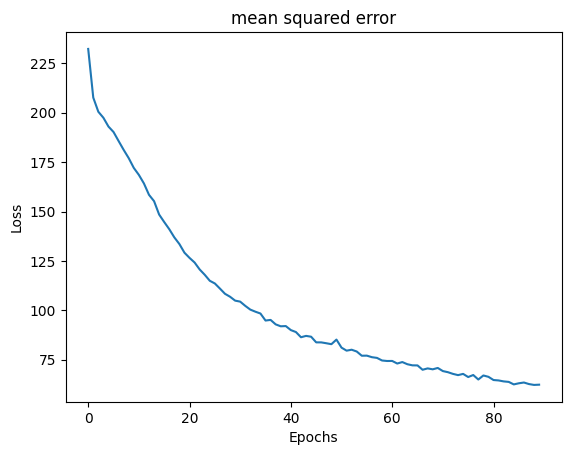

In [19]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/colorization/models/{model_name}.pth')
plot_loss(l1_hist, 'mean absolute error', f'/content/drive/MyDrive/colorization/plots/L1-{model_name}.png')
plot_loss(l2_hist, 'mean squared error', f'/content/drive/MyDrive/colorization/plots/L2-{model_name}.png')

In [20]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.2 MB/s eta 0:00:00


In [21]:
from torch.types import Device
from lpips import LPIPS

lpips_alex = LPIPS(net='alex')

def lpips_evaluate(model, loader):
    model.eval()
    model.to(device)
    running_loss = 0.0

    with torch.no_grad():
        for grayscale_images, colors in loader:
            grayscale_images = grayscale_images.to(device)
            colors = colors.to(device)

            # Forward pass
            predicted_colors = model(grayscale_images)

            # Compute the loss
            predicted_rgb = to_rgb(grayscale_images.cpu(), predicted_colors.cpu(), to_numpy = False)
            label_rgb = to_rgb(grayscale_images.cpu(), colors.cpu(), to_numpy = False)

            loss = lpips_alex(predicted_rgb, label_rgb)

            # Accumulate loss
            running_loss += loss.sum().item() / len(loss)

    # Calculate average loss
    average_loss = running_loss / len(loader)

    return average_loss


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 44.0MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


In [22]:

testloader = DataLoader(val_data, batch_size=32)
lpips_score = lpips_evaluate(model, testloader)

print(f'LPIPS results on test data:{lpips_score}')

LPIPS results on test data:0.129782407078892


# Colorizing Unseen Data with implemented model

torch.Size([2, 256, 256])
619


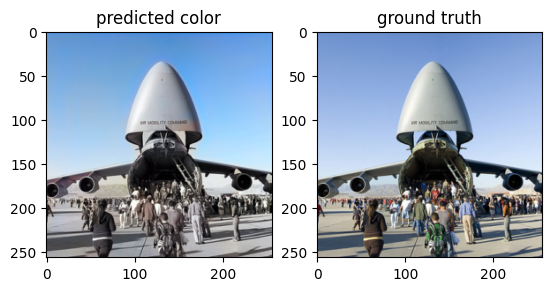

In [29]:
import random
model.eval()

index = random.randint(0,len(val_data))
input, label = val_data[index]
rgb_label = to_rgb(input, label)

input = input.to(device)
output = model(input.unsqueeze(0)).squeeze()
print(output.shape)
rgb_pred = to_rgb(input.cpu(), output.cpu())

input.shape, label.shape, output.shape
rgb_pred.shape, rgb_label.shape
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2)


axes[0].imshow(rgb_pred)
axes[0].set_title('predicted color')

axes[1].imshow(rgb_label)
axes[1].set_title('ground truth')
print(index)